In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

In [3]:
# Load dataset
df = pd.read_csv('../data/clean_reclean/time_series.csv')
# Convert Yr_MoSold to datetime
df['Date'] = pd.to_datetime(df['YrSold'].astype(str) + '-' + df['MoSold'].astype(str) + '-01')
df.set_index('Date', inplace=True)
df = df.sort_index()
df = df[['SalePrice']]
df.head()

,SalePrice
Date,
2006-01-01,181000
2006-01-01,136500
2006-01-01,423000
2006-01-01,205000
2006-01-01,260000


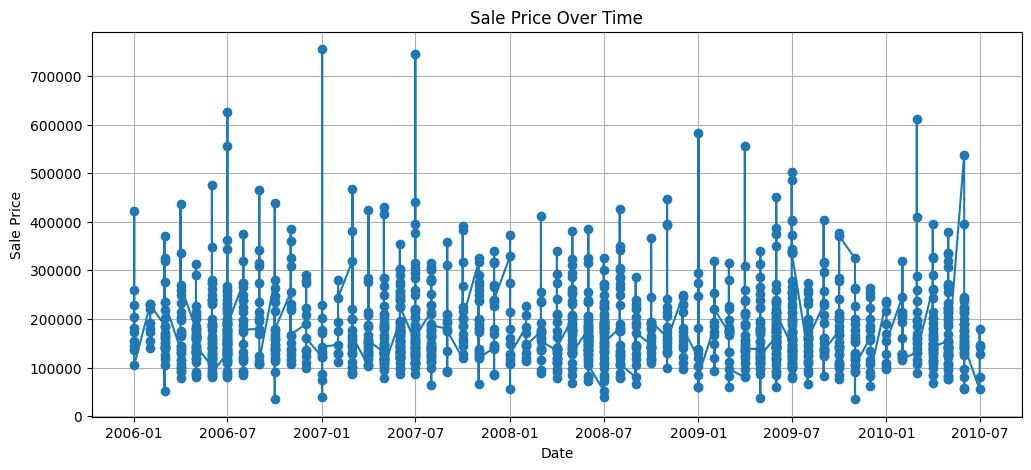

In [4]:
# Plot SalePrice over time
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['SalePrice'], marker='o', linestyle='-')
plt.title('Sale Price Over Time')
plt.xlabel('Date')
plt.ylabel('Sale Price')
plt.grid(True)
plt.show()

/tmp/ipykernel_913/1611086643.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_sim.index = pd.date_range(start='2000-01', periods=n, freq='M')


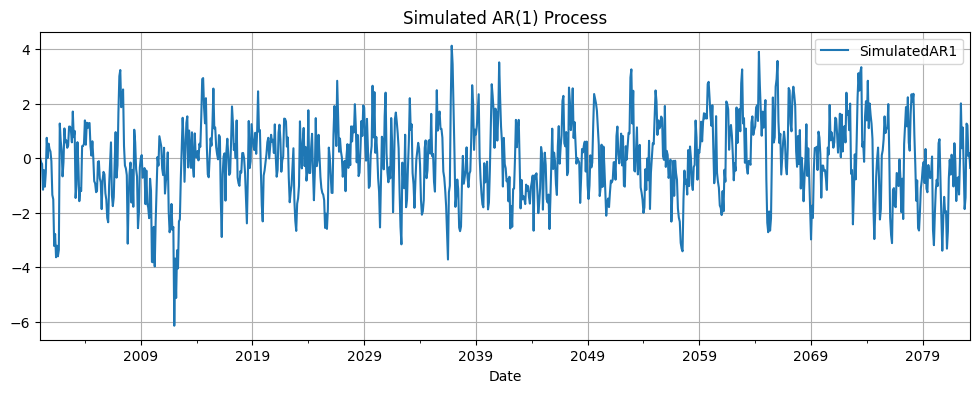

In [5]:
# Simulate AR(1)
phi = 0.7
n = 1000
sigma = 1.0
eps = np.random.normal(0, sigma, n)
x = np.zeros(n)
for t in range(1, n):
    x[t] = phi * x[t - 1] + eps[t]
df_sim = pd.DataFrame(x, columns=['SimulatedAR1'])
df_sim.index = pd.date_range(start='2000-01', periods=n, freq='M')
df_sim.index.name = 'Date'
df_sim.plot(figsize=(12, 4), title='Simulated AR(1) Process')
plt.grid(True)
plt.show()

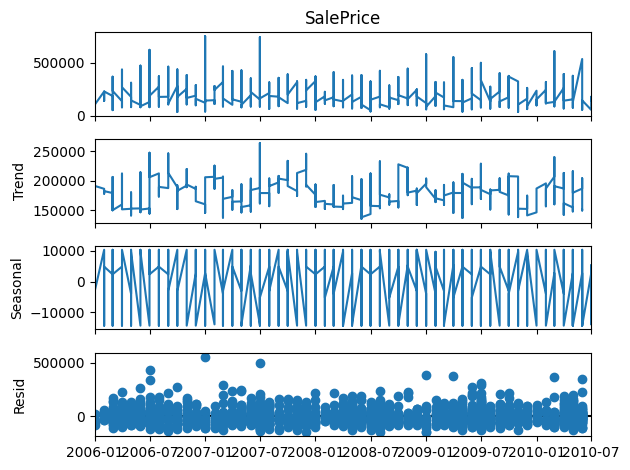

In [6]:
# Decomposition
result = seasonal_decompose(df['SalePrice'], model='additive', period=12)
result.plot()
plt.tight_layout()
plt.show()

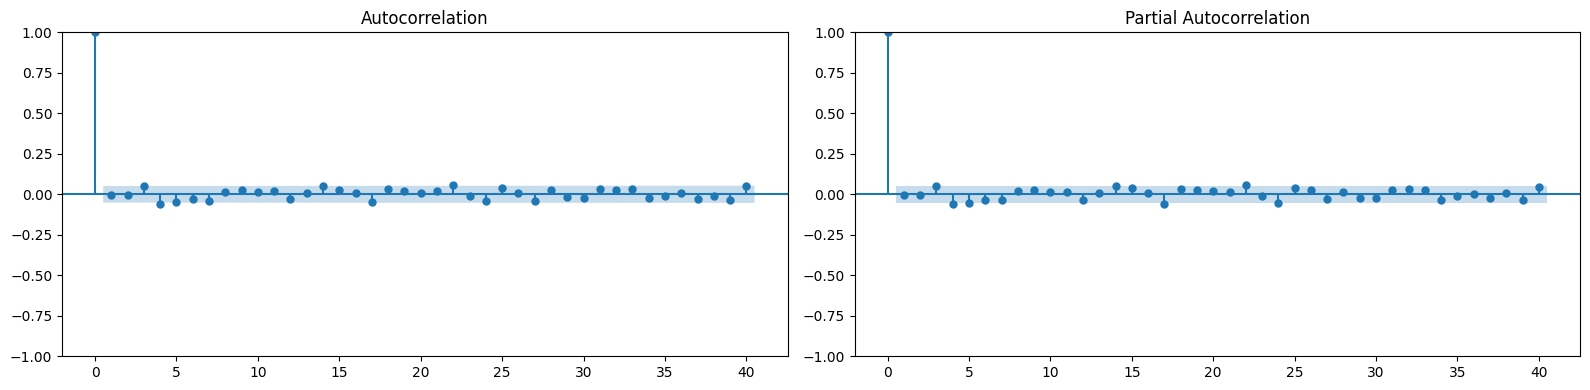

In [7]:
# ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(df['SalePrice'], ax=axes[0], lags=40)
plot_pacf(df['SalePrice'], ax=axes[1], lags=40)
plt.tight_layout()
plt.show()

/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

                               SARIMAX Results                                
Dep. Variable:              SalePrice   No. Observations:                 1460
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -18554.676
Date:                Mon, 19 May 2025   AIC                          37115.353
Time:                        11:58:40   BIC                          37131.210
Sample:                             0   HQIC                         37121.268
                               - 1460                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0040      0.039     -0.104      0.917      -0.080       0.072
ma.L1         -0.9990      0.009   -109.338      0.000      -1.017      -0.981
sigma2      7.981e+09   1.23e-12   6.48e+21      0.0

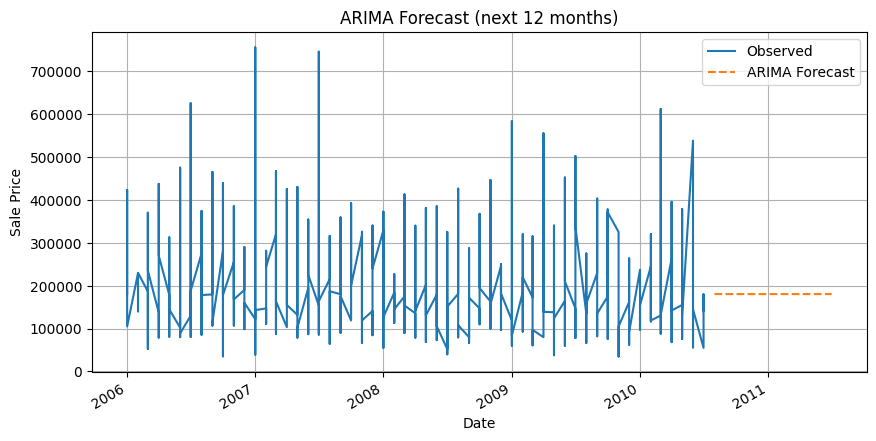

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model_arima = ARIMA(df['SalePrice'], order=(1,1,1))
results_arima = model_arima.fit()

# Summary
print(results_arima.summary())

# Forecast 12 future months
forecast_steps = 12
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
forecast_arima = results_arima.forecast(steps=forecast_steps)

# Create forecast series with proper dates
forecast_series = pd.Series(forecast_arima.values, index=future_dates)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['SalePrice'], label='Observed')
forecast_series.plot(label='ARIMA Forecast', style='--')
plt.title('ARIMA Forecast (next 12 months)')
plt.xlabel('Date')
plt.ylabel('Sale Price')
plt.legend()
plt.grid(True)
plt.show()

/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return

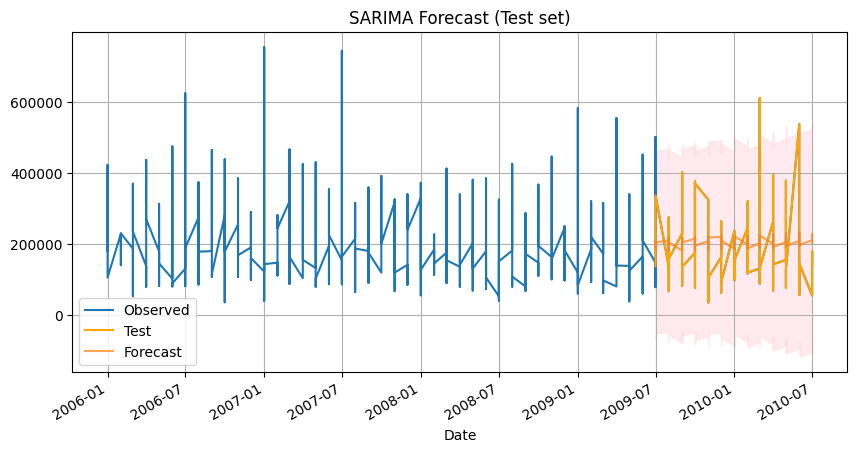

MAE: 67581.58
RMSE: 82905.18
MAPE: 50.55%


In [9]:
# Split data: 80% train, 20% test
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

# Fit SARIMA on train set (ajuste les paramètres selon ton modèle)
model_sarima = sm.tsa.statespace.SARIMAX(train['SalePrice'], order=(1,1,1), seasonal_order=(1,1,1,12))
results_sarima = model_sarima.fit()

# Forecast for the length of the test set
forecast_steps = len(test)
forecast_sarima = results_sarima.get_forecast(steps=forecast_steps)
forecast_ci = forecast_sarima.conf_int()

# Set correct index for forecast and confidence intervals
forecast_index = test.index
forecast_mean = pd.Series(forecast_sarima.predicted_mean.values, index=forecast_index)
forecast_ci.index = forecast_index

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['SalePrice'], label='Observed')
plt.plot(test.index, test['SalePrice'], label='Test', color='orange')
forecast_mean.plot(label='Forecast', alpha=0.7)
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast (Test set)')
plt.legend()
plt.grid(True)
plt.show()
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Align forecast and test set
y_true = test['SalePrice']
y_pred = forecast_mean

# MAE
mae = mean_absolute_error(y_true, y_pred)
# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
# MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Performing stepwise search to minimize aic


/var/data/python/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/data/python/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/data/python/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/data/python/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/data/python/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.w

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=29694.146, Time=0.02 sec


/var/data/python/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/data/python/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=29697.417, Time=0.46 sec


/var/data/python/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=29696.828, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=31819.711, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=29695.960, Time=0.15 sec


/var/data/python/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/data/python/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/data/python/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=29694.868, Time=0.18 sec


/var/data/python/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=29696.868, Time=0.76 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=29696.065, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=29696.078, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=29698.070, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 5.531 seconds
Best SARIMA order: (0, 0, 0)
Best seasonal order: (0, 0, 0, 12)


/var/data/python/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/data/python/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/data/python/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has

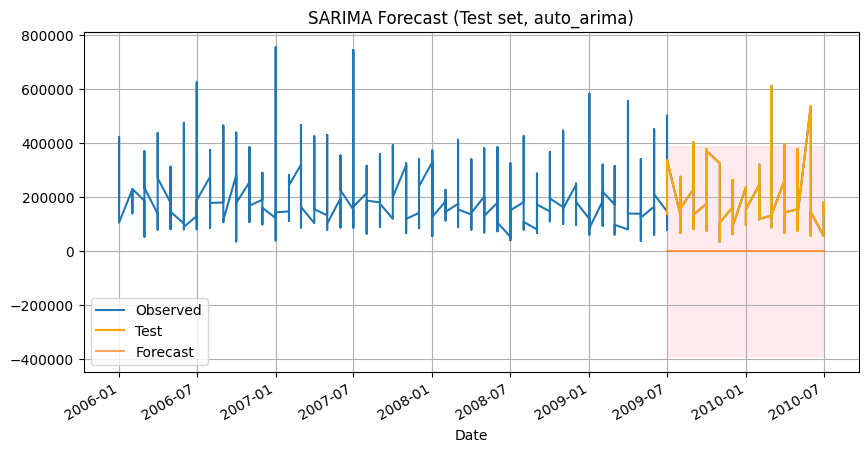

MAE: 175396.25
RMSE: 191319.42
MAPE: 100.00%


In [10]:
import pmdarima as pm

# Use auto_arima to find the best SARIMA parameters
auto_model = pm.auto_arima(
    train['SalePrice'],
    seasonal=True,
    m=12,  # 12 for yearly seasonality
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print("Best SARIMA order:", auto_model.order)
print("Best seasonal order:", auto_model.seasonal_order)

# Fit SARIMA with the best parameters
model_sarima = sm.tsa.statespace.SARIMAX(
    train['SalePrice'],
    order=auto_model.order,
    seasonal_order=auto_model.seasonal_order
)
results_sarima = model_sarima.fit()

# Forecast for the length of the test set
forecast_steps = len(test)
forecast_sarima = results_sarima.get_forecast(steps=forecast_steps)
forecast_ci = forecast_sarima.conf_int()

# Set correct index for forecast and confidence intervals
forecast_index = test.index
forecast_mean = pd.Series(forecast_sarima.predicted_mean.values, index=forecast_index)
forecast_ci.index = forecast_index

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['SalePrice'], label='Observed')
plt.plot(test.index, test['SalePrice'], label='Test', color='orange')
forecast_mean.plot(label='Forecast', alpha=0.7)
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast (Test set, auto_arima)')
plt.legend()
plt.grid(True)
plt.show()

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = test['SalePrice']
y_pred = forecast_mean

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")